In [1]:

import numpy as np
import time
#from termcolor import colored
from scipy.integrate import solve_ivp
from scipy.linalg import norm
from numpy import pi as pi
import scipy
from scipy import sparse
import scipy.sparse as sp
from scipy.sparse import csr_matrix
from numpy.random import choice, normal
from numpy import concatenate
from scipy.sparse import coo_matrix
from scipy.sparse import kron
import pandas as pd
from mpl_toolkits import mplot3d
from numba import jit
from scipy.linalg import expm
import numbers
from numpy import imag, conj, cos, sin
from numpy import sqrt, zeros, diag, random, real, array, complex_, transpose, conjugate, exp, matmul, real, dot, add, sum
import pandas as pd
from numpy import dot
from scipy.sparse import bsr_matrix

#df=pd.read_csv('Positions_2000.txt') 


t0=time.time()

Atom_cutoff=6


Gamma_r=1    #  
N_atom=600      #Number of atoms
Omega=8.00*Gamma_r   




lambda_r  =1    # in units
Lambda_las=1     # in units    Gamma_r*2*pi/(wL/c_light)   #Laser wavelenght  , What are the units?
e_L=array([0,0,1]/sqrt(1))

Theta1=pi/2
Theta2=pi/2   #they got [0,1,0]

e_0=array([0,0,1]/sqrt(1))   #array([sin(Theta1)*cos(Theta2),sin(Theta1)*sin(Theta2),cos(Theta1)])

K_laser=(2*pi/Lambda_las)*array([1,0,0])
k0=2*pi/Lambda_las
Gamma_dec=Gamma_r

# Clebsch-Gordan coefficient

# Clebsch-Gordan coefficient
C00=1    

# Positions


## Oblate Variances matrix: Set the shape of the atoms cloud

## Oblate Variances matrix: Set the shape of the atoms cloud
Sigma_x=20 *lambda_r    
Sigma_y=0.5*lambda_r 
Sigma_z=Sigma_y         
    


Oblate_variances=zeros((3,3))

Oblate_variances[0][0]=Sigma_x**2
Oblate_variances[1][1]=Sigma_y**2
Oblate_variances[2][2]=Sigma_z**2

Miu_pos=[0 , 0, 0]

Pos_atoms=(random.multivariate_normal(Miu_pos, Oblate_variances, N_atom))

#Pos_atoms=array(df)



Pos_atoms=Pos_atoms[Pos_atoms[:,0].argsort()]


#for j in range(N_atom):
#    Pos_atoms[j]=np.array([100.35*Lambda_las*j,0,0])
  
# 2*np.pi

#Pos_atoms
#Pos_atoms 

#for j in range(N_atom):
#    Pos_atoms[j]=np.array([0.1*Lambda_las*j,0,0])








# In[ ]:





# In[2]:




# Construct $I_{Lk}$ and $R_{Lk}$


# Construct I_Lk and R_Lk

eL_e0c=dot(e_L,conj(e_0))

conj_0=conj(e_0)

DotKL_rk=[]   #summarize k_L.r_k for all k

for j in range(N_atom):
    DotKL_rk.append(dot(Pos_atoms[j],K_laser))

DotKL_rk_exp=exp(-1j*array(DotKL_rk))


ZL_k= DotKL_rk_exp*eL_e0c


ImL_k=imag(ZL_k)
RmL_k=real(ZL_k)


# Construct $G_{ij}$

# Construct the matrix R00
#t0=time.time()

@jit
def fun_Pkl0(k,l,k0=k0):
    
    VecR_kl=Pos_atoms[k]-Pos_atoms[l]
    R_kl=sqrt(dot(VecR_kl,VecR_kl))
    #R_kl=norm(VecR_kl)
    
    
    #Pkl0=dot(conj(e_0),VecR_kl)
    Pkl0=dot(conj_0,VecR_kl)/R_kl
    Pkl_0nC=(abs(Pkl0))**2
    
    M0kl=k0*R_kl
    
    return (1-Pkl_0nC)/M0kl+(1-3*Pkl_0nC)*(1j/(M0kl)**2-1/(M0kl)**3)
    


MatL=zeros((N_atom,N_atom),dtype='complex64')
MatR=zeros((N_atom,N_atom),dtype='complex64')


for i in range(N_atom):
    for j in range(i+1,N_atom):

        VecR_ij=Pos_atoms[i] -Pos_atoms[j]

        MatL[i][j]=exp(1j*k0*sqrt(dot(VecR_ij,VecR_ij)))
        MatR[i][j]=fun_Pkl0(i,j,k0)

                
MatR=MatR+MatR.T
MatL=MatL+(MatL.T)


Gij=(3*Gamma_dec/4)*MatL*MatR


#t1=time.time()

Gij=Gij + 1j*0.5*Gamma_r*np.identity(N_atom) 

Abs_Gij=abs(Gij)

ReG=real(Gij)
ImG=imag(Gij)


Collect    =0

#t0=time.time()


# In[ ]:





# In[3]:



Random_signature=np.random.rand(1,1)[0,0].round(6)



Sigma_eg=csr_matrix(np.array([[0,1],
                              [0,0]]),dtype="complex64")
Id_2LS  =csr_matrix(np.array([[1,0],
                              [0,1]]),dtype="complex64")

Zero_2LS=csr_matrix(np.array([[0,0],
                              [0,0]]),dtype="complex64")

state   =csr_matrix(np.array([[0,0],
                              [0,1]]),dtype="complex64")


Sigma_ee=csr_matrix(np.array([[1,0],
                              [0,0]]),dtype="complex64")

Sigma_egT=Sigma_eg.T    




def index_Gij(arr,Atom_cutoff):
    
    Ordered_N = list(np.argsort(arr)[::-1][:Atom_cutoff])
    
    return Ordered_N

Index_N=[]

Rem_iden=abs(Gij - 1j*0.5*Gamma_r*np.identity(N_atom))


for j in range(Rem_iden.shape[0]):
    
    test_list = list(Rem_iden[j])
    
    Index_N.append( [j]+list(index_Gij(test_list,Atom_cutoff-1))  )



# In[ ]:





# In[ ]:





# In[4]:



#@jit
def tensor_id(ArrayL ):
    
    Tensor_id=kron(ArrayL[0],ArrayL[1])
    
    Array_id=Atom_cutoff*[Id_2LS]    
    
    for j in range(2,len(ArrayL)):
        
        Tensor_id=kron(Tensor_id,Array_id[j])
        
    
    Ten_s=csr_matrix(Tensor_id)
    
    csr_matrix.eliminate_zeros(Ten_s)  #remove zeros!!!
    
    return coo_matrix(Ten_s)



#@jit
def tensor_kj( k , j):   #tensor among k,j are Positions in the cluster after the G classification
                         #k is +sigma and j is -sigma 
    Array_id=Atom_cutoff*[Id_2LS]  
    
    Array_id[k]=Sigma_eg
    Array_id[j]=Sigma_egT
    
    Tensor_kj=kron(Array_id[0],Array_id[1])
    
    for j in range(2,len(Array_id)):
        
        Tensor_kj=kron(Tensor_kj,Array_id[j])
        
        csr_matrix.eliminate_zeros(csr_matrix(Tensor_kj))
        
        
            
    Ten_kj=csr_matrix( Tensor_kj ) 
        
    csr_matrix.eliminate_zeros(Ten_kj)
        
        
    
    return coo_matrix(Ten_kj)



#@jit
def tensor_k_ee( k  ):  #Excited state k is a Position in the cluster after the G classification
    
    Array_id=Atom_cutoff*[Id_2LS]  
    
    Array_id[k]=Sigma_ee
    
    Tensor_k    =kron(Array_id[0],Array_id[1])
    
    for j in range(2,len(Array_id)):
        
        Tensor_k=kron(Tensor_k,Array_id[j])
        
    
    
    Tensor_k=csr_matrix( Tensor_k ) 
    
    csr_matrix.eliminate_zeros(Tensor_k)
        
    
    return coo_matrix(Tensor_k)



#@jit
def tensor_k( k ):  #sigmaplus k
    
    Array_id=Atom_cutoff*[Id_2LS]  
    
    Array_id[k]=Sigma_eg
    
    Tensor_k    =kron(Array_id[0],Array_id[1])
    
    for j in range(2,len(Array_id)):
        
        Tensor_k=kron(Tensor_k,Array_id[j])
        
    
    Tensor_k=csr_matrix( Tensor_k ) 
    
    csr_matrix.eliminate_zeros(Tensor_k)
        
    
    return coo_matrix(Tensor_k)



#@jit
def init_rho(Atom_cutoff=Atom_cutoff,state=state):
    
    state_fact=Atom_cutoff*[state]
    
    Rho_in=kron(state_fact[0],state_fact[1])
    
    for j in range(2,Atom_cutoff):
        
        Rho_in=kron(Rho_in,state_fact[j])
        
        
    Rho_in=csr_matrix( Rho_in ) 
    
    csr_matrix.eliminate_zeros(Rho_in)
    
    
        
    return coo_matrix(Rho_in)





#@jit
def Hamil_atom(index_center):
    
    Index_list=Index_N[index_center]
    Zero_gen=tensor_id(Atom_cutoff*[ Zero_2LS ])
    Z2=Zero_gen
    
    for k in range(Atom_cutoff):
        
        IL_k = Index_list[k]
        
        #print(IL_k)
        
        zL_k = ZL_k[IL_k]
        Ten_k= tensor_k(k)
        
        Z2   = Z2 -(Omega)*(zL_k*Ten_k  +conj(zL_k)*(Ten_k.T) )
        
    return Z2

Sigma_EGalt=(tensor_k(0)).reshape(1,4**Atom_cutoff)
Sigma_EEalt=(tensor_k_ee(0)).reshape(1,4**Atom_cutoff)
Sigma_Min_alt=(tensor_k(0).T).reshape(1,4**Atom_cutoff)


Ivec=[4**Atom_cutoff-1]

Jvec=[0]
Vvec=[1]


Init_rho=(sparse.coo_matrix((Vvec,(Ivec,Jvec)),shape=(4**Atom_cutoff,1))) 


    #@jit
def f(t, yR,M_vect,b):
 
    MatA=M_vect@yR
    return MatA



def Hamil_effec(i_index, Expect_minus):   #this is just for the site labelled by index_center
    
    Vect_Gi=Gij[i_index]
    
    All_Ind_effective_drive=dot(Vect_Gi,Expect_minus.todense())[0,0]
    
    return All_Ind_effective_drive

#Hamil_effec(0, Sigma_m_rev[:,0])




def GdotMinus(Expect_minus):
    
    return (Expect_minus.T).dot(Gij)




Rho_t= sparse.lil_matrix((4**Atom_cutoff, N_atom),dtype="complex64")   #saves the density matrices for a given time t
for j in range(N_atom):
    Rho_t[:,j]=Init_rho


        
tfinal=14
Lenght=3000
tspan=np.linspace(0,tfinal,Lenght)    #Here the time definition is important because it will tell you how to divide the elements



Sigma_m_rev=  sparse.lil_matrix((N_atom, len(tspan)),dtype="complex64")
Sigma_ee_rev= sparse.lil_matrix((N_atom, len(tspan)),dtype="complex64")


size_1=int(N_atom*(N_atom))




Sigma_ip_jp   = sparse.lil_matrix((size_1, len(tspan)),dtype="complex64")
Sigma_ip_jm   = sparse.lil_matrix((size_1, len(tspan)),dtype="complex64")
Sigma_ip_jee  = sparse.lil_matrix((size_1, len(tspan)),dtype="complex64")
Sigma_iee_jp  = sparse.lil_matrix((size_1, len(tspan)),dtype="complex64")
Sigma_iee_jee = sparse.lil_matrix((size_1, len(tspan)),dtype="complex64")







for j in range(N_atom):
    
    Sigma_m_rev[j,0] =Sigma_Min_alt.dot( Rho_t[:,j])[0,0]
    Sigma_ee_rev[j,0]=Sigma_EEalt.dot( Rho_t[:,j])[0,0]
    

#Sigma_m_rev[:,0][1,0]




def hamil_clust(index_center,ind_ref,Expect_minus):
    
    
    Index_list=Index_N[index_center]
    
    ind_ref=Index_list[ind_ref]
    
    Driv_clust=0
    
    for ind_list in Index_list:
        
        Driv_clust=Driv_clust+Gij[ind_ref, ind_list ]*Expect_minus[ind_list , 0 ]
    
    return Driv_clust
        

#Gmin[Index_list[j],0] 



def Effec_Hamil( index_center ,tind_):
    
    Expect_minus=Sigma_m_rev[:,tind_]
    
    Index_list=Index_N[index_center]
    
    Gmin=GdotMinus(Sigma_m_rev[:,tind_])
    
    H_effect = 0*tensor_k(0)
    
    for k in range(Atom_cutoff):
        H_effect = H_effect -(Gmin[0,Index_list[k]]  -  hamil_clust(index_center , k  ,Expect_minus)  ) * tensor_k(k)
    
    return (H_effect+conj(H_effect.T))



def Part_H_L_R_LR(index_center):
    
    Array_id=Atom_cutoff*[Id_2LS] 
    Index_list=Index_N[index_center]
    Zero_gen=tensor_id(Atom_cutoff*[ Zero_2LS ])
    
    Z1=Zero_gen
    Z2=Zero_gen
    Z3=kron(Zero_gen,Zero_gen)
    
    
    Col_Decay=kron(Zero_gen,Zero_gen)
    
    Identity=tensor_id( Atom_cutoff*[Id_2LS])
    
    Col=Collect
    
    D_R = Zero_gen
    D_L = Zero_gen
    D_RL= kron(Zero_gen,Zero_gen)

    Hamil=Zero_gen
    
    Splus=Zero_gen
    
    
    Hamil_at=Hamil_atom(index_center)   
    Hamil_vect= -1j *(kron(Identity,  Hamil_at )-kron(Hamil_at.T,Identity))
    
    for k in range(Atom_cutoff):
        
        IL_k = Index_list[k]

        zL_k = ZL_k[IL_k]

        Ten_k= tensor_k(k)
        
        Ten_k_ee=tensor_k_ee(k)
        
        
        Splus=Splus+Ten_k
        
        Imkk=ImG[k,k]  
        
        
            #Z2   = Z2+ 1j*(Omega)*(zL_k*Ten_k  +conj(zL_k)*(Ten_k.T) )
        
        
        D_R   = D_R  - ( Imkk       )*Ten_k_ee
        D_L   = D_L  - ( Imkk       )*Ten_k_ee
        D_RL  = D_RL + ( 2 * Imkk    )*kron( Ten_k.T , Ten_k.T  )

        for j in range(k+1,Atom_cutoff):
            
            IL_j  =Index_list[j]

            Ten_kj= tensor_kj( k , j )
            
            ReGkj=ReG[IL_k,IL_j] 
            ImGkj=ImG[IL_k,IL_j]
            ReGjk=ReGkj   
            ImGjk=ImGkj
            
            
            Z1=Z1+ (1j*ReGkj-ImGkj)*(Ten_kj+ Ten_kj.T  )
            
            Ten_j=tensor_k(j)
            
            
            Tenk_Tenj=kron(Ten_k.T,Ten_j.T)

            Tenj_Tenk=kron(Ten_j.T,Ten_k.T)
            
            
            Z3=Z3+2*( ImGkj*Tenk_Tenj   +  ImGjk* Tenj_Tenk )

            #print( tensor_kj( k , j ).todense(), ReG[IL_k,IL_j],(IL_k,IL_j)  )
            
            #print(k,j)



            Hamil=Hamil+(1j*ReGkj)*(Ten_kj+ Ten_kj.T)

    Hamil=Hamil+Hamil_at                 
        
    L_R = Z2+Z1
    L_L =-(Z2.T)+conj(Z1.T) 
    L_RL=Z3
    

    #print(L_R.shape, L_L.shape, L_RL.shape)
    
    Vectorization=  ( kron(Identity,  L_R+D_R )+kron(L_L+D_L,Identity )+L_RL+D_RL ) #   + Col * Col_Decay  )

    
    return  Vectorization+Hamil_vect  #, Hamil #cl_sparse(Vectorization) #clean_sparse(Vectorization)




def Part_time_dep(index_center,tind_):

    Identity=tensor_id( Atom_cutoff*[Id_2LS])
    
    Hamil_at  =  Effec_Hamil( index_center ,tind_)  #Put zero to ignore mean-field 
    Hamil_vect= -1j *(kron(Identity,  Hamil_at )-kron(Hamil_at.T,Identity))
        
    return  Hamil_vect  #, Hamil #cl_sparse(Vectorization) #clean_sparse(Vectorization)



ty=time.time()


Time_ind_hamil=[]   #Calculates all the time-independent Lindblandian vectorized

for cent_ind in range(N_atom):
    
    Time_ind_hamil.append(Part_H_L_R_LR(cent_ind))
    
    #print(cent_ind*100/N_atom)
    
    
tv=time.time()

print(tv-ty)



def rho_part(Rho_mt,inst_time):
    
    Result_fin=Rho_mt

    for cent_ind in range(N_atom):
        
        #Mat_dyn=Time_ind_hamil[cent_ind]   #+Part_time_dep(cent_ind,inst_time)
        
        Mat_dyn=Time_ind_hamil[cent_ind]+Part_time_dep(cent_ind,inst_time)
        
        sol_cent_ind = solve_ivp(f,[tspan[inst_time],tspan[inst_time+1]],list(array((Rho_mt[:,cent_ind].todense()).T,dtype="complex")[0])
                                 ,args=(Mat_dyn,None),dense_output=False , t_eval= [tspan[inst_time+1]])
        
        Result_fin[:,cent_ind]=sol_cent_ind.y
        
        #print(cent_ind)
        
    return Result_fin
        



#@jit    plus-plus

def tensor_kjpp( k , j):   #tensor among k,j are Positions in the cluster after the G classification
                         #k is +sigma and j is -sigma 
    Array_id=Atom_cutoff*[Id_2LS]  
    
    Array_id[k]=Sigma_eg
    Array_id[j]=Sigma_eg
    
    Tensor_kj=kron(Array_id[0],Array_id[1])
    
    for j in range(2,len(Array_id)):
        
        Tensor_kj=kron(Tensor_kj,Array_id[j])
        csr_matrix.eliminate_zeros(csr_matrix(Tensor_kj))
        
    Ten_kj=csr_matrix( Tensor_kj ) 
    csr_matrix.eliminate_zeros(Ten_kj)
        
    return coo_matrix(Ten_kj)



#@jit   plus-minus
def tensor_kjpm( k , j):   #tensor among k,j are Positions in the cluster after the G classification
                         #k is +sigma and j is -sigma 
    Array_id=Atom_cutoff*[Id_2LS]  
    Array_id[k]=Sigma_eg
    Array_id[j]=Sigma_egT
    
    Tensor_kj=kron(Array_id[0],Array_id[1])
    
    for j in range(2,len(Array_id)):
        
        Tensor_kj=kron(Tensor_kj,Array_id[j])
        csr_matrix.eliminate_zeros(csr_matrix(Tensor_kj))
        
    Ten_kj=csr_matrix( Tensor_kj ) 
    csr_matrix.eliminate_zeros(Ten_kj)
    
    return coo_matrix(Ten_kj)



#@jit   plus-ee
def tensor_kjp_ee( k , j):   #tensor among k,j are Positions in the cluster after the G classification
                         #k is +sigma and j is -sigma 
    Array_id=Atom_cutoff*[Id_2LS]  
    Array_id[k]=Sigma_eg
    Array_id[j]=Sigma_ee
    
    Tensor_kj=kron(Array_id[0],Array_id[1])
    
    for j in range(2,len(Array_id)):
        
        Tensor_kj=kron(Tensor_kj,Array_id[j])
        csr_matrix.eliminate_zeros(csr_matrix(Tensor_kj))
        
    Ten_kj=csr_matrix( Tensor_kj ) 
    csr_matrix.eliminate_zeros(Ten_kj)
    
    return coo_matrix(Ten_kj)



#@jit   e-pluse
def tensor_kjee_p( k , j):   #tensor among k,j are Positions in the cluster after the G classification
                         #k is +sigma and j is -sigma 
    Array_id=Atom_cutoff*[Id_2LS]  
    Array_id[k]= Sigma_ee
    Array_id[j]= Sigma_eg
    
    Tensor_kj=kron(Array_id[0],Array_id[1])
    
    for j in range(2,len(Array_id)):
        
        Tensor_kj=kron(Tensor_kj,Array_id[j])
        csr_matrix.eliminate_zeros(csr_matrix(Tensor_kj))
        
    Ten_kj=csr_matrix( Tensor_kj ) 
    csr_matrix.eliminate_zeros(Ten_kj)
    
    return coo_matrix(Ten_kj)



#@jit  ee-ee
def tensor_kj_ee_ee( k , j):   #tensor among k,j are Positions in the cluster after the G classification
                         #k is +sigma and j is -sigma 
    Array_id=Atom_cutoff*[Id_2LS]  
    Array_id[k]=Sigma_ee
    Array_id[j]=Sigma_ee
    
    Tensor_kj=kron(Array_id[0],Array_id[1])
    
    for j in range(2,len(Array_id)):
        
        Tensor_kj=kron(Tensor_kj,Array_id[j])
        csr_matrix.eliminate_zeros(csr_matrix(Tensor_kj))
        
    Ten_kj=csr_matrix( Tensor_kj ) 
    csr_matrix.eliminate_zeros(Ten_kj)
    
    return coo_matrix(Ten_kj)



#Sigma_Min_alt=(kron(tensor_k(0),tensor_k(1))).reshape(1,16**Atom_cutoff)


#Collect the correlation matrices


Arr_pp    = []
Arr_pm    = []
Arr_p_ee  = []
Arr_ee_p  = []
Arr_ee_ee = []


k0=0
for j1 in range(k0+1,Atom_cutoff):
        
    Arr_pp.append( tensor_kjpp( k0 , j1 ).reshape(1,4**Atom_cutoff))
    Arr_pm.append( tensor_kjpm( k0 , j1 ).reshape(1,4**Atom_cutoff))
    Arr_p_ee.append(tensor_kjp_ee( k0 , j1).reshape(1,4**Atom_cutoff))
    Arr_ee_ee.append( tensor_kj_ee_ee(k0 , j1).reshape(1,4**Atom_cutoff))
    Arr_ee_p.append(tensor_kjee_p( k0 , j1).reshape(1,4**Atom_cutoff))


def decis_correl(x_ref, y_v, Index_N=Index_N):
    
    Ind_ref=Index_N[x_ref]
    
    if y_v in Ind_ref:
        
        return True
    
    else:
        
        return False


def index_ov_x_ref(x_ref, y_v, Index_N=Index_N):
    
    Ind_ref=Index_N[x_ref]
    
    return Ind_ref.index(y_v)   # y_v must be in the list to avoid errors


Rho0= sparse.lil_matrix((4**Atom_cutoff, N_atom),dtype="complex64")   #saves the density matrices for a given time t
for j in range(N_atom):
    Rho0[:,j]=Init_rho


#for i in range(N_atom):
#    for j in range(i+1,N_atom):
#        print(i,j)



Desicion_array=sparse.lil_matrix((size_1, 2),dtype="complex64")


contador=0


for i0 in range(N_atom):
        
    for j1 in range(N_atom):
        
        if i0!=j1:
            
            Bool_val=decis_correl(i0, j1, Index_N=Index_N)
            
            if Bool_val:
                
                Desicion_array[contador,0]=Bool_val
                Desicion_array[contador,1]=index_ov_x_ref(i0, j1, Index_N=Index_N)
    
        contador=contador+1


Ar_bool_index=array(real(Desicion_array.todense()).astype(int))

#Sigma_ip_jp   = sparse.lil_matrix((size_1, len(tspan)),dtype="complex64")
#Sigma_ip_jm   = sparse.lil_matrix((size_1, len(tspan)),dtype="complex64")
#Sigma_ip_jee  = sparse.lil_matrix((size_1, len(tspan)),dtype="complex64")
#Sigma_iee_jp  = sparse.lil_matrix((size_1, len(tspan)),dtype="complex64")
#Sigma_iee_jee = sparse.lil_matrix((size_1, len(tspan)),dtype="complex64")


#Arr_pp    = []
#Arr_pm    = []
#Arr_p_ee  = []
#Arr_ee_p  = []
#Arr_ee_ee = []



contador=0
for i0 in range(N_atom):
        
    ip  = conj(Sigma_m_rev[i0,0])
    iee = Sigma_ee_rev[i0,0]
        
    for j1 in range(N_atom):
            
        jp  = conj(Sigma_m_rev[j1,0])
        jee = Sigma_ee_rev[j1,0]
            
             
        if i0!=j1:
                
            Sigma_ip_jp[contador  ,0] = ip*jp
            Sigma_ip_jm[contador  ,0] = ip*conj(jp)
            Sigma_ip_jee[contador ,0] = ip*jee 
            Sigma_iee_jp[contador ,0] = iee*jp
            Sigma_iee_jee[contador,0] = iee*jee
                    
        elif i0==j1:
                
            #Sigma_ip_jp[contador ,0]   = 0
            Sigma_ip_jm[contador,0]   = iee
            #Sigma_ip_jee[contador,0]  = 0 
            #Sigma_iee_jp[contador,0]  = 0
            Sigma_iee_jee[contador,0] = iee
                
        contador=contador+1


# In[ ]:





# In[5]:



number_parts=15


index_parts=int(len(tspan)/number_parts)

tnew=[]

for tind_ in range(len(tspan)-1):

    Time_pos=int((tind_+1)//index_parts)
    
    if (tind_+1)%index_parts==0:
        
        tnew.append(tspan[tind_+1])

tnew=array(tnew)

siz_x=len(tnew)+1

Sigma_m_rev_red = sparse.lil_matrix((N_atom, siz_x),dtype="complex64")
Sigma_ee_rev_red = sparse.lil_matrix((N_atom, siz_x),dtype="complex64")
Sigma_ip_jm_red = sparse.lil_matrix((size_1, siz_x),dtype="complex64")

tred=[]


for j in range(number_parts):
    
    tred.append(tspan[j*index_parts])
    
tred=array(tred)    



Time_pos=int((tind_+1)//index_parts)


Time_pos



Sigma_m_rev_red = sparse.lil_matrix((N_atom, siz_x),dtype="complex64")
Sigma_ee_rev_red = sparse.lil_matrix((N_atom, siz_x),dtype="complex64")
Sigma_ip_jm_red = sparse.lil_matrix((size_1, siz_x),dtype="complex64")




index_parts



Time_alte=[0]



Ty0=time.time()


for tind_ in range(len(tspan)-1):
    
    Rho0=rho_part(Rho0,tind_)
    
    Sigma_m_rev[ :,tind_+1] = (array(Sigma_Min_alt.dot( Rho0 ).todense().T)).round(5)
    #Sigma_ee_rev[:,tind_+1] = (array(Sigma_EEalt.dot( Rho0 ).todense().T)).round(5)
    
    
    if (tind_+1)%index_parts==0:
        
        Sigma_ee_rev_red[:,(tind_+1)//index_parts] = (array(Sigma_EEalt.dot( Rho0 ).todense().T)).round(5)
        Sigma_m_rev_red[ :,(tind_+1)//index_parts] = (array(Sigma_Min_alt.dot( Rho0 ).todense().T)).round(5)
        
        print(100*(tind_+1)/len(tspan))
        
        Time_alte.append(tspan[tind_+1])
    
      
        
        for i0 in range(N_atom):
        
            Index_i0=Index_N[i0][1:]

            for j1 in range(Atom_cutoff-1):
             
                j1_indector=Index_i0[j1]
                contador=i0*N_atom+j1_indector
            
                    
                Ind_j1=Ar_bool_index[contador,1]-1
                    
                #Oper_ip_jp   = Arr_pp[Ind_j1]
                Oper_ip_jm   = Arr_pm[Ind_j1]
                #Oper_ip_jee  = Arr_p_ee[Ind_j1]
                #Oper_iee_jp  = Arr_ee_p[Ind_j1]
                #Oper_iee_jee = Arr_ee_ee[Ind_j1]
                    
                    
                #Sigma_ip_jp[contador,tind_+1]  =Oper_ip_jp.dot( Rho0[:,i0] )[0,0]
                Sigma_ip_jm_red[contador,(tind_+1)//index_parts]  =(Oper_ip_jm.dot( Rho0[:,i0] )[0,0]).round(5)
                #Sigma_ip_jee[contador,tind_+1] =Oper_ip_jee.dot( Rho0[:,i0] )[0,0]
                #Sigma_iee_jp[contador,tind_+1] =Oper_iee_jp.dot( Rho0[:,i0] )[0,0]
                #Sigma_iee_jee[contador,tind_+1]=Oper_iee_jee.dot( Rho0[:,i0] )[0,0]
        
        
    #print(str((tind_+1)*100/len(tspan)))
    
    
Ty1=time.time()


print(Ty1-Ty0)


# In[ ]:





# In[6]:


# In[ ]:





# In[7]:



# In[ ]:





Time_alte=array(Time_alte).reshape(len(Time_alte),1)



Smin_primed=((DotKL_rk_exp).reshape(1,N_atom)@Sigma_m_rev_red).reshape(len(Time_alte),1)
Smin_primed2=(((DotKL_rk_exp).reshape(1,N_atom)@conj(Sigma_m_rev_red))).T
     




Tim0  = Time_alte
See0  = (array((array(sum(Sigma_ee_rev_red,axis=0)).T).round(5) ).reshape(len(Time_alte),1))
Res_conc=np.concatenate((Tim0,See0,Smin_primed,Smin_primed2),axis=1)
Res_conc=np.concatenate((Res_conc[0].reshape(1,len(Res_conc[0])),Res_conc),axis=0)
file = open(str(N_atom)+"_"+str(Random_signature)+"TSeeSminp"+"_Cluster_size_"+str(Atom_cutoff)+"_Omega_"+str(Omega)+"_Lax_"+str(Sigma_x)+"_Tspan_"+str(tspan[0])+"-"+str(tspan[tind_])+".txt", "w+")
np.savetxt(file, Res_conc, delimiter=',')
file.write('\n')
file.write('\n')
file.close()


# In[25]:




for tind_ in range(len(Time_alte)-1):
    
    contador=0
    for i0 in range(N_atom):
        
        ip  = conj(Sigma_m_rev_red[i0,tind_+1])
        iee = Sigma_ee_rev_red[i0,tind_+1]
        
        for j1 in range(N_atom):
            
            jp  = conj(Sigma_m_rev_red[j1,tind_+1])
            #jee = Sigma_ee_rev[j1,tind_+1]
            
             
            if i0!=j1:
                
                if not Ar_bool_index[contador,0]:
                    
                    #Ind_j1=Ar_bool_index[contador,1]-1
                
                    #Sigma_ip_jp[contador,tind_+1]   = ip*jp
                    Sigma_ip_jm_red[contador,tind_+1]   = ip*conj(jp)
                    #Sigma_ip_jee[contador,tind_+1]  = ip*jee 
                    #Sigma_iee_jp[contador,tind_+1]  = iee*jp
                    #Sigma_iee_jee[contador,tind_+1] = iee*jee
                    
            elif i0==j1:
                
                #Sigma_ip_jp[contador,tind_+1]   = 0
                Sigma_ip_jm_red[contador,tind_+1]   = iee
                #Sigma_ip_jee[contador,tind_+1]  = 0 
                #Sigma_iee_jp[contador,tind_+1]  = 0
                #Sigma_iee_jee[contador,tind_+1] = iee
                
            contador=contador+1
            
    print(str((tind_+1)*100/len(Time_alte)))


    
    
    
    

    
    
    
    
    
    

N_atom


# In[ ]:


x_siz=int(N_atom*(N_atom))
y_siz=len(Time_alte)

PP_ar=np.zeros((x_siz,y_siz),dtype="complex64")
PM_ar=np.zeros((x_siz,y_siz),dtype="complex64")
PP_ar=np.zeros((x_siz,y_siz),dtype="complex64")
PP_ar=np.zeros((x_siz,y_siz),dtype="complex64")



# In[ ]:

Exp_factor=np.zeros((x_siz,1),dtype="complex64")


# In[ ]:


contador=0

for i0 in range(N_atom):
    for j1 in range(N_atom):
        
        Exp_factor[contador,0]=exp(-1j*dot(K_laser,Pos_atoms[i0]-Pos_atoms[j1]))
        
        contador=contador+1
             
    
#Exp_factor           


# In[ ]:


Exp_factor=Exp_factor.T




# In[ ]:



for tin in range(len(Time_alte)):
    
    contador=0
    
    for i0 in range(N_atom):
        for j1 in range(N_atom):
            
            #print(contador)
        
            index_a=i0*N_atom+j1
            index_b=j1*N_atom+i0
        
            PM_ar[contador,tin]=( (Sigma_ip_jm_red[index_a,tin]+conj(Sigma_ip_jm_red[index_b,tin]))/2  )
        
            contador=contador+1
    
    print(str((tin+1)*100/len(Time_alte)))


# In[ 



F_intens=(Exp_factor@PM_ar)[0]
F_intens1=(conj(Exp_factor)@PM_ar)[0]

# In[ ]:


See0  = array(sum(Sigma_ee_rev_red,axis=0)).reshape(len(Time_alte),1)
Smin0=  array(sum(Sigma_m_rev_red,axis=0)).reshape(len(Time_alte),1)

Fint= array((Exp_factor@PM_ar)[0]).reshape(len(Time_alte),1)
Fint1= array((conj(Exp_factor)@PM_ar)[0]).reshape(len(Time_alte),1)






Res_conc=np.concatenate((Time_alte,See0,Smin_primed,Smin_primed2,Fint,Fint1),axis=1)
Res_conc=np.concatenate((Res_conc[0].reshape(1,len(Res_conc[0])),Res_conc),axis=0)
file = open("_F1F0_"+str(N_atom)+str(Random_signature)+"FinF0F1_Results"+"_Cluster_size_"+str(Atom_cutoff)+"_Omega_"+str(Omega)+"_Lax_"+str(Sigma_x)+"_Tspan_"+str(tspan[0])+"-"+str(tspan[tind_])+".txt", "w+")
np.savetxt(file, Res_conc, delimiter=',')
file.write('\n')
file.write('\n')
file.close()    


# In[ ]:





# In[ ]:





# In[ ]:



def peak_inte(Phi_obs=0,Theta_obs=0):
   
    e_k_las=2*pi*array([cos(Phi_obs),sin(Phi_obs)*sin(Theta_obs),sin(Phi_obs)*cos(Theta_obs)])
    
    
    Exp_factor=np.zeros((x_siz,1),dtype="complex64")


    # In[ ]:


    contador=0

    for i0 in range(N_atom):
        for j1 in range(N_atom):
        
            Exp_factor[contador,0]=exp(-1j*dot(e_k_las,Pos_atoms[i0]-Pos_atoms[j1]))
        
            contador=contador+1
             
    
#Exp_factor           


# In[ ]:


    Exp_factor=Exp_factor.T
    
    F_intens=(Exp_factor@PM_ar)[0]
    
    return max(F_intens), F_intens[-1]
    
    
    
    


Theta_val=np.linspace(-np.pi,np.pi,120)
Max_peak=[]

St_inten=[]
Tot_exc=[]


for j in Theta_val:
    
    Valus=peak_inte(j)
    
    Max_peak.append(Valus[0])
    St_inten.append(Valus[1])
    
    Tot_exc.append(See0[-1])
    

Theta_val=array(Theta_val)
Max_peak =array(Max_peak)
St_inten=array(St_inten)

Theta_val=array(Theta_val).reshape(Theta_val.shape[0],1)
Max_peak =array(Max_peak).reshape(Max_peak.shape[0],1)
St_inten=array(St_inten).reshape(St_inten.shape[0],1)





Res_conc=np.concatenate((Theta_val,Max_peak ,St_inten),axis=1)
Res_conc=np.concatenate((Res_conc[0].reshape(1,len(Res_conc[0])),Res_conc),axis=0)
file = open("_Theta_prof_"+str(N_atom)+str(Random_signature)+"FinF0F1_Results"+"_Cluster_size_"+str(Atom_cutoff)+"_Omega_"+str(Omega)+"_Lax_"+str(Sigma_x)+"_Tspan_"+str(tspan[0])+"-"+str(tspan[tind_])+".txt", "w+")
np.savetxt(file, Res_conc, delimiter=',')
file.write('\n')
file.write('\n')
file.close()    



# In[ ]:





# In[ ]:





# In[ ]:





# In[ ]:





# In[36]:


#import matplotlib.pyplot as plt

#plt.plot(Time_alte,See0)


# In[ ]:





# In[ ]:





# In[ ]:





# In[ ]:





# In[ ]:





# In[ ]:






80.32588958740234
6.666666666666667
13.333333333333334
20.0
26.666666666666668
33.333333333333336
40.0
46.666666666666664
53.333333333333336
60.0
66.66666666666667
73.33333333333333
80.0
86.66666666666667
93.33333333333333
86498.81401538849
6.666666666666667
13.333333333333334
20.0
26.666666666666668
33.333333333333336
40.0
46.666666666666664
53.333333333333336
60.0
66.66666666666667
73.33333333333333
80.0
86.66666666666667
93.33333333333333
6.666666666666667
13.333333333333334
20.0
26.666666666666668
33.333333333333336
40.0
46.666666666666664
53.333333333333336
60.0
66.66666666666667
73.33333333333333
80.0
86.66666666666667
93.33333333333333
100.0


In [2]:
import matplotlib.pyplot as plt

In [3]:
#plt.plot(Time_alte, Fint)

Fint[-4:]

array([[655.5392 +1.4901161e-07j],
       [656.3441 -3.6358833e-06j],
       [655.2499 -2.4139881e-06j],
       [655.18695+1.4901161e-06j]], dtype=complex64)

C:\Users\camil\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


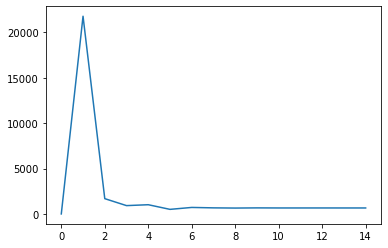

In [4]:
plt.plot(Fint)

In [5]:
Fint

array([[    0.     +0.0000000e+00j],
       [21773.074  -2.4414062e-04j],
       [ 1681.9637 -2.5749207e-05j],
       [  914.5806 -3.0994415e-05j],
       [ 1013.0482 +2.3484230e-05j],
       [  501.6391 -5.4240227e-06j],
       [  713.49066-2.8610229e-06j],
       [  666.67834+3.6656857e-06j],
       [  645.15656-1.4901161e-07j],
       [  663.62524+5.7816505e-06j],
       [  655.72327-9.2387199e-07j],
       [  655.5392 +1.4901161e-07j],
       [  656.3441 -3.6358833e-06j],
       [  655.2499 -2.4139881e-06j],
       [  655.18695+1.4901161e-06j]], dtype=complex64)

In [6]:
Omega

8.0

In [7]:
np.mean(Fint[-4:])

(655.58-1.1026859e-06j)

In [8]:
N_atom

600